<a href="https://colab.research.google.com/github/god05212/analyze-data/blob/main/analyze_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사용한 데이터셋
> Video Games Sales Dataset: Video Games Sales & Game Ratings Data Scraped from VzCharts
- https://www.kaggle.com/sidtwr
- https://www.kaggle.com/sidtwr/videogames-sales-dataset

1. 주제 : 다음 분기에 어떤 게임을 설계해야 할까
2. 대상 : 비데이터 직군
3. 목표 : 해당 주제에 대한 분석 설명 영상(5분) 발표를 통한 분석정보 전달   
4. 필수분석 내용   
  1) 지역에 따라서 선호하는 게임 장르가 다를까  
  2) 연도별 게임의 트렌드가 있을까  
  3) 매출이 높은 게임에 대한 분석 및 시각화 프로세스

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [ ]:
url ="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv"

df = pd.read_csv(url, index_col=0)
pd.set_option("max_rows", 10000)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [ ]:
print(df.shape) # 데이터 shape확인
print(df.isnull().sum()) # 데이터 결측치 확인
print(df.dtypes) # 데이터타입확인 

In [ ]:
# object 데이터 확인 
df.describe(include=["O"])

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16598,16598,16548,16540,16598,16598,16598,16598
unique,11493,31,12,578,494,363,282,190
top,Need for Speed: Most Wanted,DS,Action,Electronic Arts,0,0,0,0
freq,12,2163,3305,1351,4443,5665,10333,6386


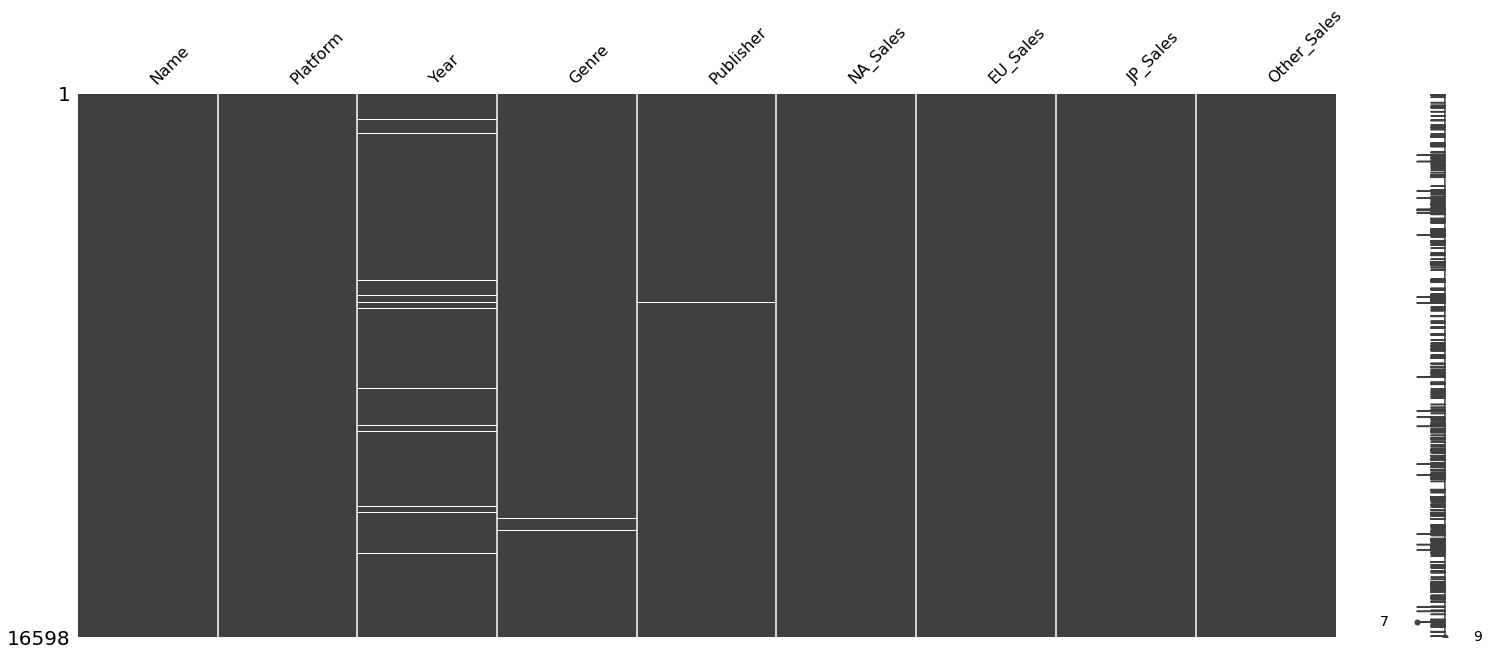

In [ ]:
# 각 컬럼별 데이터 결측치 시각화
msno.matrix(df);

검정색으로 색칠된 부분이 데이터가 제대로 입력된 부분이며, 중간중간 가로로 줄이 그어진 부분이 데이터가 누락된 부분입니다.  
아래 그림과 비교하였을 때 저희 데이터는 결측치가 적은 양질의 데이터로 분석되었음을 안내드립니다.  

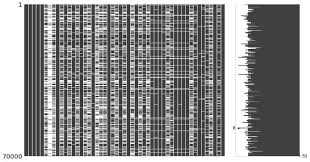

## 데이터 전처리 결과 보고 
#### 1. 총 데이터 row수 : 16598개 
#### 2. drop한 데이터 row수 : 457개
    2-1) 결측치 데이터 row 수 : 357개   
    *데이터 10%미만 데이터 드랍 근거(paper) : https://www.jstatsoft.org/article/view/v045i03/v45i03.pdf 
    2-2) 연도가 오기재된 데이터 row 수 : 100개
    *사유1 : 오래된 게임은 현재 트랜드를 반영하지 못함
    *사유2 : 추정하여 연도를 찾는다하여도 정확한 데이터인지 확인불가
    *사유3 : 오기재된 데이터 비율은 총 데이터의 5%미만에 해당되므로 drop함 
#### 결론 : drop한 데이터는 전체 데이터의 약 2.8%이며, 10% 미만이기에 drop함  



In [ ]:
# 결측치 drop
df = df.dropna(axis=0)
df.shape

(16241, 9)

In [ ]:
# 연도가 오기재된 데이터 drop
df = df[df["Year"] > 1900]
df.shape

(16141, 9)

In [ ]:
# 매출액 단위 M(million으로 통일)
lists = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
for list in lists :
  df[list] = (df[list].replace(r'[KM]+$', '', regex=True).astype(float) * df[list].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**-3, 10**1]).astype(int))

In [ ]:
# 연도 데이터 OBJECT -> INT 전환
df['Year'] = df['Year'].astype(int)

In [ ]:
# 게임별 매출액 산출( add sum column )
df["sum"] = df["NA_Sales"]+df["EU_Sales"]+df["JP_Sales"]+df["Other_Sales"]
df = df.sort_values(ascending=False, by="sum")
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,sum
10914,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,96.30,5.31,0.06,1.38,103.05
2909,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
12601,Halo: Reach,X360,2010,Shooter,Microsoft Game Studios,70.30,1.98,0.08,0.78,73.14
578,Mario Kart 64,N64,1996,Racing,Nintendo,55.50,1.94,2.23,0.15,59.82
8534,Pokémon Yellow: Special Pikachu Edition,GB,1998,Role-Playing,Nintendo,5.89,5.04,31.20,0.59,42.72
...,...,...,...,...,...,...,...,...,...,...
12507,Kidou Senshi Gundam: Giren no Yabou - Axis no ...,PSP,2008,Strategy,Namco Bandai Games,0.00,0.00,0.00,0.00,0.00
14799,Eyeshield 21: Max Devil Power,DS,2006,Role-Playing,Nintendo,0.00,0.00,0.00,0.00,0.00
3446,Toaru Majutsu no Kagaku no Ensemble,PSP,2013,Adventure,Namco Bandai Games,0.00,0.00,0.00,0.00,0.00
10647,Genroh,PSP,2012,Action,Idea Factory,0.00,0.00,0.00,0.00,0.00


# 1) [필수분석 내용] 지역에 따라서 선호하는 게임 장르가 다를까?

### 위 내역을 확인하기 위해 각 지역별 매출액을 확인한 결과, 
### NA : Action
### EU : Action
### JP : Role-playing 
### Other : Action 

### 각 지역별로 Action 게임이 매출액이 켰다. 
### 지역에 관계없이 Action 게임을 대부분 좋아한다는 사실을 유추하였다.

In [ ]:
na_sales =df['NA_Sales'].groupby(df['Genre']).sum()
eu_sales =df['EU_Sales'].groupby(df['Genre']).sum()
jp_sales =df['JP_Sales'].groupby(df['Genre']).sum()
other_Sales =df['Other_Sales'].groupby(df['Genre']).sum()

sales = pd.concat([na_sales, eu_sales, jp_sales, other_Sales], axis=1)

sales

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,978.89,533.59,156.99,186.60
Adventure,105.47,63.63,51.91,18.36
Fighting,224.25,98.60,96.65,39.20
Misc,393.50,211.66,105.19,75.38
Platform,456.34,255.08,134.23,52.07
Puzzle,121.03,53.58,56.19,12.84
Racing,406.22,246.26,55.34,76.61
Role-Playing,309.38,190.50,403.97,61.99
Shooter,644.56,328.94,37.48,104.08


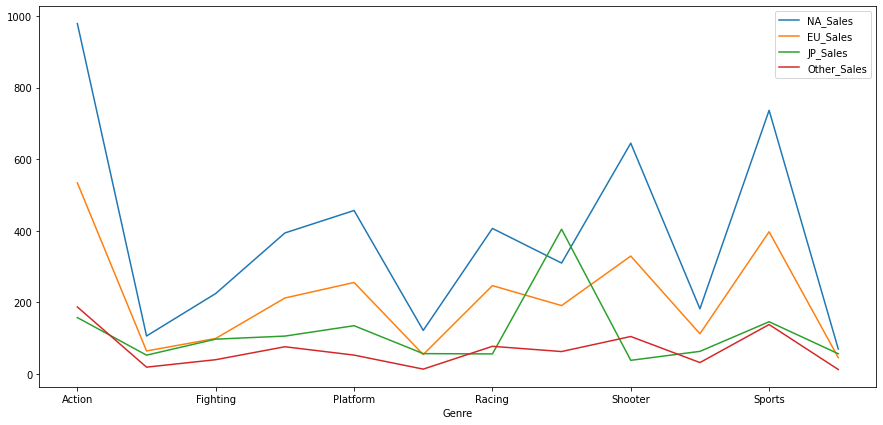

In [ ]:
sales.plot(figsize= [15, 7]);

# 2) [필수분석 내용] 연도별 게임의 트렌드가 있을까?

### 연도별 게임 트렌드를 파악하기 위해 
### 각 연도별로 출시된 게임을 카운트하였다. 
### 액션 게임의 증가 폭이 가장 크며  
### 그 뒤를 이어 음악과 스포츠, 어드밴처 게임이 급증하였음을 볼 수 있다.

In [ ]:
df1 = df[["Year", "Genre", "Publisher"]]
data = pd.pivot_table(data=df1, index="Year", columns="Genre", aggfunc = "count")
data = data.apply(pd.to_numeric, errors="coerce").fillna(0)

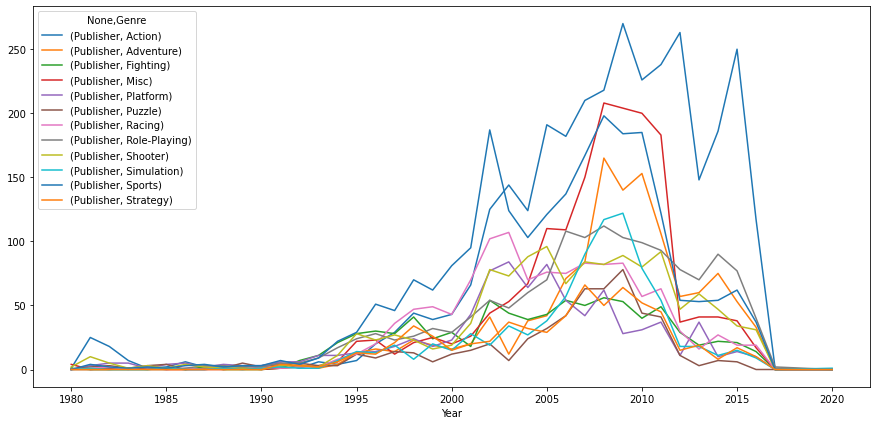

In [ ]:
data.plot(figsize= [15, 7]);

# 3) [필수분석 내용] 매출이 높은 게임에 대한 분석 및 시각화 프로세스

In [ ]:
# 매출액에서 상위 20개의 게임만 별도로 데이터 생성
# 결국 우리는 게임을 만들어 돈을 벌려고 하기 때문에 매출액이 좋은 게임들을 분석할 필요가 있음 
df1 = df.iloc[0:20, :]

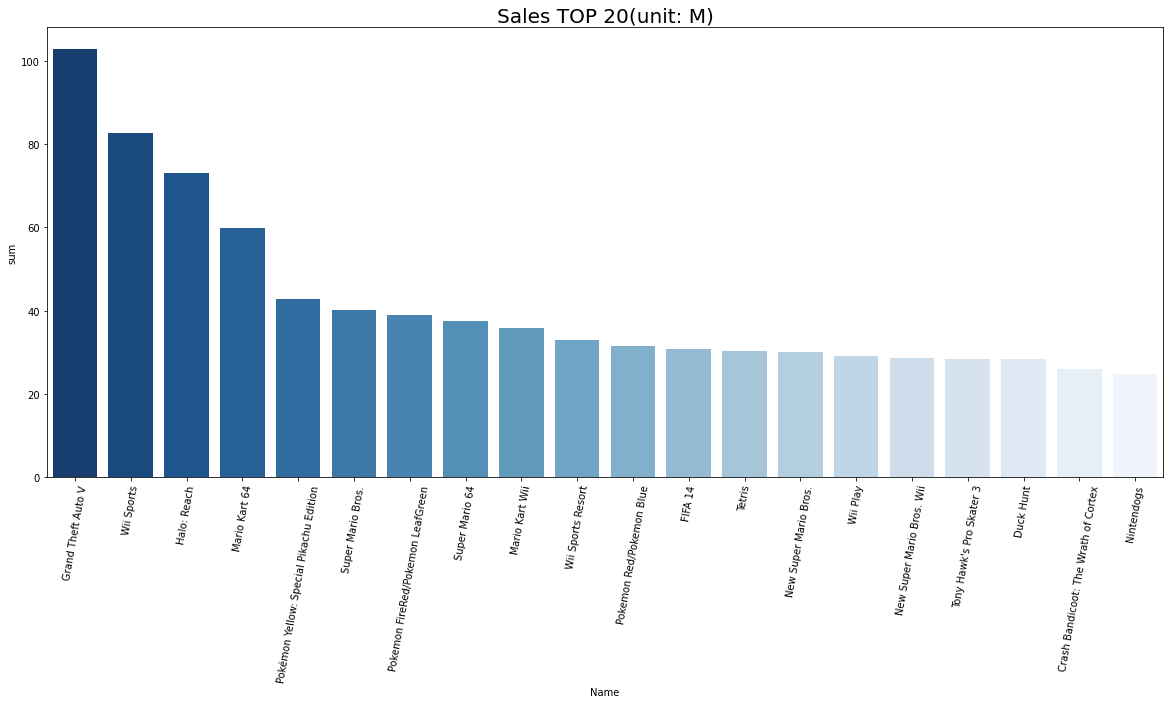

In [ ]:
a4_dims = (20, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.barplot(data=df1, x="Name", y="sum", palette="Blues_r")


plt.xticks(rotation=80) ## x축 눈금 라벨 설정 - 40도 회전 
plt.title('Sales TOP 20(unit: M)',fontsize=20) ## 타이틀 설정
plt.show()


In [ ]:
# 해당 데이터에서 가장 최신 게임의 트랜드와 매출액을 보기 위해 df2 생성
df2 = df1[df1["Year"] > 2005]

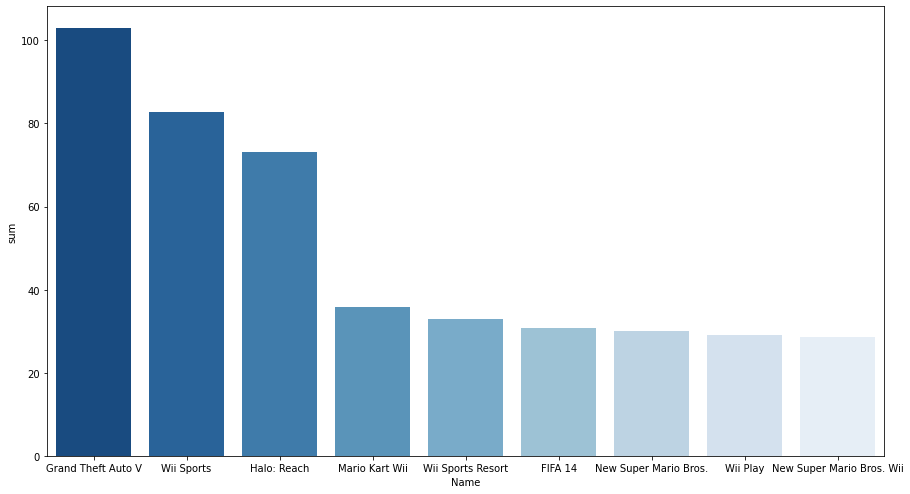

In [ ]:
a4_dims = (15, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.barplot(data=df2, x="Name", y="sum", palette="Blues_r");

### 위 결과를 종합하여 보았을 때 
### 다음 분기에 제작해야하는 게임의 장르는 Action 게임이 타당하다 사료됨 

### 추가적인 담당자 소견 
### 1) 마리오 게임이 시리즈별로 일정한 매출액을 보이며 
### 2) 닌텐도 게임이 매출액 TOP20에서 다수 관찰됨을 보았을 때 
### 3) 닌텐도 & 마리오 게임에 대한 추가적인 분석이 필요하다 사료됩니다. 
###   ( 연령층, 게임별 단가, 시리즈별 차이점 등 ) 